### MEMO_0825 (v0825_1.0)

### _* Memo_0825_3_

In [40]:
## Configuration

version="memo_0825_3"
next_round = 1187

title = "Metrics"
row_length = 400
new_to_old = True
show_mark_down = True
markdown_table_limit_length = 20
op_with_re = False
db_path = '../db/metrics.db'

In [88]:
## this code was run.
#!pip install keras-tuner
# import numpy as np
# import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
# print(f'Current Step #01 [now = {datetime.now()}')
from IPython.display import Markdown
import sys

sys.path.append("/home/jovyan/work/LSTM_Analyze/foresttrans")

from lib.analy_util import ( draw_markdown,
                             draw_graph,
                             draw_scatter,
                             get_pre_bef,
                             draw_average,
                             get_frequency,
                             get_information,
                             analyze_v1,
                             data_prepare,
                             search_model,
                             get_information_v2,
                             get_extdatas,
                             )
print(f'define this code. [{datetime.now()}]')


define this code. [2025-08-27 13:46:26.549304]


In [89]:
def get_candidated(version: str):
    """ get_candidated """
    query = f'select n0, n1, n2, n3, n4, n5 from candidated where version=\\"{version}\\";'
    metrics = !echo "{query}" | sqlite3 {db_path}
    if len(metrics) == 1:
        metrics = metrics[0].split('|')
        if len(metrics) == 6:
            return {0: int(metrics[0]),
                    1: int(metrics[1]),
                    2: int(metrics[2]),
                    3: int(metrics[3]),
                    4: int(metrics[4]),
                    5: int(metrics[5])}
    return {}


def set_candidated_level(version: str, level: int):
    """ set_candidated_level """
    """ candidated의 level을 설정합니다. """ 
    up_query = f'update candidated set level={level} where version=\\"{version}\\";'
    !echo "{up_query}" | sqlite3 {db_path}


def get_candidated_level(version: str):
    """ get_candidated_level """
    """ level을 가져 옵니다. """
    sel_query = f'select level from candidated where version=\\"{version}\\";'
    levels = !echo "{sel_query}" | sqlite3 {db_path}

    if len(levels) > 0:
        return int(levels[0])
    return 0


def update_candidated(candidated: dict, version: str):
    """ update_candidated """
    sel_query = f'select * from candidated where version=\\"{version}\\";'
    metrics = !echo "{sel_query}" | sqlite3 {db_path}
    if len(metrics) == 1:
        """ update """
        update_query = 'update candidated set '
        set_kv = []
        for key in candidated.keys():
            set_kv.append(f'n{key}={candidated[key]}')
        update_query += ", ".join(set_kv)
        update_query += f' where version=\\"{version}\\";'
        !echo "{update_query}" | sqlite3 {db_path}
    else:
        """ insert """
        insert_query = 'insert into candidated ('
        new_key = []
        new_val = []
        for key in candidated.keys():
            new_key.append(f'n{key}')
            new_val.append(f'{candidated[key]}')
        new_key.append('version')
        new_val.append(f'\\"{version}\\"')
        insert_query += f'{", ".join(new_key)} ) values ('
        insert_query += f'{", ".join(new_val)} );'
        !echo "{insert_query}" | sqlite3 {db_path}


def create_candidated():
    """ create_candidated """
    new_query = 'create table candidated ( ' \
                ' id INTEGER PRIMARY KEY AUTOINCREMENT, ' \
                ' version char[14], ' \
                ' n0 int, ' \
                ' n1 int, ' \
                ' n2 int, ' \
                ' n3 int, ' \
                ' n4 int, ' \
                ' n5 int );'
    !echo "{new_query}" | sqlite3 {db_path}


def draw_nums(ext_datas, is_pre_data=False, fig_size=(15, 8)):
    """ draw_nums """
    show_cols = [0, 1, 2, 3, 4, 5]
    show_label = False
    show_cnt = 100
    start_pos = row_length - show_cnt
    show_data = []
    for i in range(6):
        end_pos = -1 if is_pre_data else len(row_list_none_last[i])
        show_data.append(row_list_none_last[i][start_pos:end_pos])
    print(ext_datas)
    draw_scatter(show_data, f'line num : {key}', True, True, show_cols, ext_datas, show_label, helper_line_nums=[10, 20, 30, 40], fig_size=fig_size)


# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
def get_likey(like_query, next_round):
    """ get_likey """
    rows = !echo "{like_query}" | sqlite3 {db_path}
    cur_next_round = next_round
    if len(rows) > 0:
        for row in rows:
            cols = row.split("|")
            nums = [int(i) for i in cols[2].split(',')]
            nums_str = [f"{int(i): >2}" for i in nums]
            round_diff = 0
            cur_round = int(cols[1])        
            if next_round > 0:
                round_diff = cur_next_round - cur_round
            cur_next_round = cur_round
            print(f"{cur_round: >4} | {','.join(nums_str)} | {sum(nums): >3} | {round_diff: >3}")
    else:
        print('data is empty.')


def get_level_count(nums:[], level=10):
    """ get_level_count """
    level_dict = {}
    for num in nums:
        level_val = num - (num % level)
        if level_val in level_dict:
            level_dict[level_val] += 1
        else:
            level_dict[level_val] = 1
    sorted_dict = dict(sorted(level_dict.items()))
    return sorted_dict


print('current work', datetime.now())
# create_candidated()
print(f'code defined {datetime.now()}')
cur_level = get_candidated_level(version=version)

current work 2025-08-27 13:46:26.761925
code defined 2025-08-27 13:46:26.762328


In [90]:
## 레벨을 설정합니다.
## 변경시에는 아래의 cur_level을 해제하고 실행하여야 합니다.
db_level = get_candidated_level(version=version)
print(f'cur_level = {cur_level}, db_level = {db_level}')
if cur_level != db_level:
    set_candidated_level(version=version, level=cur_level)
    db_level = get_candidated_level(version=version)
    print(f'cur_level = {cur_level}, db_level = {db_level}')
# cur_level = 1

cur_level = 1, db_level = 1


In [91]:
######################
#예측 값을 가져옵니다.
######################
candidate = get_candidated(version=version)
if len(candidate.keys()) == 0:
    candidate = {0:1, 1:13, 2:21, 3:25, 4:28, 5:31}
print('candidate = ', candidate)


candidate =  {0: 3, 1: 11, 2: 12, 3: 19, 4: 32, 5: 38}


In [92]:
######################
#마지막 값을 가져 옵니다.
######################
query = 'select round, metric, bonus from results'
query += f' order by round desc '
query += f'limit 1'
rows = !echo "{query}"| sqlite3 {db_path}
cols = rows[0].split('|')
latest_nums = [int(i) for i in cols[1].split(',')]

print('latest_nums = ', latest_nums)

latest_nums =  [2, 8, 13, 16, 23, 28]


In [93]:
# Display the variable's value in Markdown
contents = f"###### Updated {datetime.now()}\n\n### {title}\n"
query = 'select round, metric, bonus from results'
query += f' order by round {"desc" if new_to_old else "asc"}'
limit_str = f'limit {row_length}'
query += f' {limit_str if row_length > 0 else ""}'
rows = !echo "{query}"| sqlite3 {db_path}
table_rows = ["|round|numbers|bonus|sum|0|10|20|30|40|",
              "|--|--|--|--|--|--|--|--|--|"
             ]
rows_dict = {1:[], 10:[], 20:[], 30:[], 40:[]}
nums_t = []
sums = []
cur_table_limit = 0
print(f'row\'s len = {len(rows)}')
candidate_strs = [f"{i}" for i in candidate.values()]
skip_first = True
for row in rows:
    if skip_first:
        row = f"{next_round}|{",".join(candidate_strs)}|0"
        skip_first = False
    cols = row.split('|')
    if len(cols) == 3:
        num_00 = 0
        num_10 = 0
        num_20 = 0
        num_30 = 0
        num_40 = 0
        nums_list = [int(i) for i in cols[1].split(',')]
        for num in nums_list:
            if num < 10:
                num_00 += 1
            if num >= 10 and num < 20:
                num_10 += 1
            if num >= 20 and num < 30:
                num_20 += 1
            if num >= 30 and num < 40:
                num_30 += 1
            if num >= 40 :
                num_40 += 1
        rows_dict[1].append(num_00)
        rows_dict[10].append(num_10)
        rows_dict[20].append(num_20)
        rows_dict[30].append(num_30)
        rows_dict[40].append(num_40)
        if cur_table_limit < markdown_table_limit_length:
            nums=[f"{i:02}" for i in nums_list] 
            table_rows.append(f"|{cols[0]}|{",".join(nums)}|{cols[2]}|{sum(nums_list)}|{num_00}|{num_10}|{num_20}|{num_30}|{num_40}|")
            cur_table_limit += 1
        nums_t.append(nums_list)
        sums.append(sum(nums_list))
sums.reverse()
table_rows_str = "\n".join(table_rows)
contents+=table_rows_str + "\n" + f"###### Updated {datetime.now()}"
Markdown(contents)

row's len = 400


###### Updated 2025-08-27 13:46:27.715584

### Metrics
|round|numbers|bonus|sum|0|10|20|30|40|
|--|--|--|--|--|--|--|--|--|
|1187|03,11,12,19,32,38|0|115|1|3|0|2|0|
|1186|02,08,13,16,23,28|35|90|2|2|2|0|0|
|1185|06,17,22,28,29,32|38|134|1|1|3|1|0|
|1184|14,16,23,25,31,37|42|146|0|2|2|2|0|
|1183|04,15,17,23,27,36|31|122|1|2|2|1|0|
|1182|01,13,21,25,28,31|22|119|1|1|3|1|0|
|1181|08,10,14,20,33,41|28|126|1|2|1|1|1|
|1180|06,12,18,37,40,41|3|154|1|2|0|1|2|
|1179|03,16,18,24,40,44|21|145|1|2|1|0|2|
|1178|05,06,11,27,43,44|17|136|2|1|1|0|2|
|1177|03,07,15,16,19,43|21|103|2|3|0|0|1|
|1176|07,09,11,21,30,35|29|113|2|1|1|2|0|
|1175|03,04,06,08,32,42|31|95|4|0|0|1|1|
|1174|08,11,14,17,36,39|22|125|1|3|0|2|0|
|1173|01,05,18,20,30,35|3|109|2|1|1|2|0|
|1172|07,09,24,40,42,44|45|166|2|0|1|0|3|
|1171|03,06,07,11,12,17|19|56|3|3|0|0|0|
|1170|03,13,28,34,38,42|25|158|1|1|1|2|1|
|1169|05,12,24,26,39,42|20|148|1|1|2|1|1|
|1168|09,21,24,30,33,37|29|154|1|0|2|3|0|
###### Updated 2025-08-27 13:46:27.731842

In [94]:
# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
print(f'Round|Metrics{" "*12}|Sum  |Width\n{"-"*40}')

### 선택번호와 비슷한 영역의 데이터 출력
like_query = 'select * from results where metric like \\"1,%,%,%,%,36\\" order by round desc;'
get_likey(like_query, next_round)

print(f'\nSelected Data\n')
print(f'Round|Metrics{" "*12}|Sum  |Width\n{"-"*40}')

### 선택 데이터 출력
candid_strs = [f"{i: >2}" for i in candidate.values()]
print(f'1185 | {",".join(candid_strs)} | {sum(list(candidate.values())): >3} |   0')
previous_round = (next_round-2, next_round-1)
previous_query = f'select * from results where round in {previous_round} order by round desc;'
get_likey(previous_query, next_round)

### 선택 번호와 비슷한 영역의 데이터 앞 출력
like_query_2 = 'select round from results where metric like \\"1,%,%,%,%,36\\" order by round desc;'
rounds = !echo "{like_query_2}" | sqlite3 {db_path}
wanted_rounds = []
for round in rounds:
    round = int(round)
    wanted_rounds.append((round-2, round-1, round))

for wanted_round in wanted_rounds:
    print(f"\n{"-"*40}")
    range_query = f'select * from results where round in {wanted_round} order by round desc;'
    get_likey(range_query, next_round)


Round|Metrics            |Sum  |Width
----------------------------------------
 804 |  1,10,13,26,32,36 | 118 | 383
 750 |  1, 2,15,19,24,36 |  97 |  54

Selected Data

Round|Metrics            |Sum  |Width
----------------------------------------
1185 |  3,11,12,19,32,38 | 115 |   0
1186 |  2, 8,13,16,23,28 |  90 |   1
1185 |  6,17,22,28,29,32 | 134 |   1

----------------------------------------
 804 |  1,10,13,26,32,36 | 118 | 383
 803 |  5, 9,14,26,30,43 | 127 |   1
 802 | 10,11,12,18,24,42 | 117 |   1

----------------------------------------
 750 |  1, 2,15,19,24,36 |  97 | 437
 749 | 12,14,24,26,34,45 | 155 |   1
 748 |  3,10,13,22,31,32 | 111 |   1


In [95]:
"""
data preparation
"""

#########
# nums_t
nums_by_row = [[] for i in range(6)]
for nums in nums_t:
    for i in range(6):
        nums_by_row[i].append(nums[i])
for i in range(6):
    nums_by_row[i].reverse()

##########
# row_list
row_list = []
row_list_none_last = []
for nums in nums_by_row:
    row_list.append(nums[0:-1])
    row_list_none_last.append(nums[0: len(nums)-1])

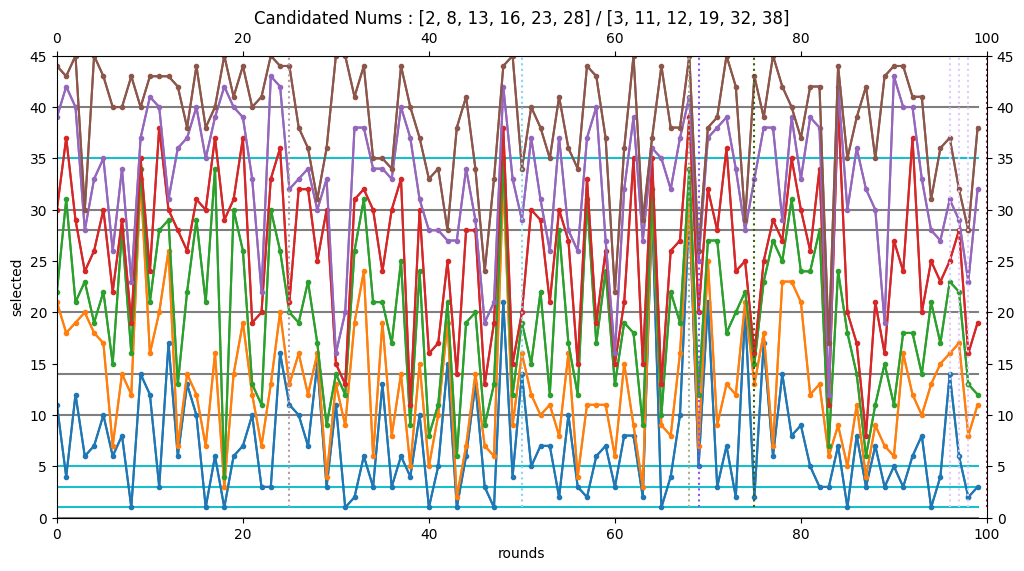

execute this code. [2025-08-27 13:46:28.758494]


In [96]:
ext_datas = []

for key in candidate:
    ext_datas.append((key, candidate[key]))

# show_cols = [0, 1, 2, 3, 4, 5]
show_cols = [0, 1, 2, 3, 4, 5]
show_label = False
show_cnt = 100

start_pos = row_length - show_cnt

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, show_cnt // 25 +1):
    vline_poses.append((25*i, 0, 45))
vline_poses.append((68, 0, 45))
vline_poses.append((69, 0, 45))

draw_scatter(Y=show_data,
             title=f'Candidated Nums : {latest_nums} / {list(candidate.values())}',
             show_line=True,
             show_dot=True,
             show_cols=show_cols,
             ext_datas=ext_datas,
             show_label=show_label,
             helper_line_nums=[0, 1, 3, 5, 10, 14, 20, 28, 30, 35, 40, 45],
             marker_size=3,
             fig_size=(12,6),
             save_fig=False,
             show_time=False,
             vline_poses=vline_poses,
             vline_color="random",
            )
print(f'execute this code. [{datetime.now()}]')
# 3, 11, 14, 18, 32, 38

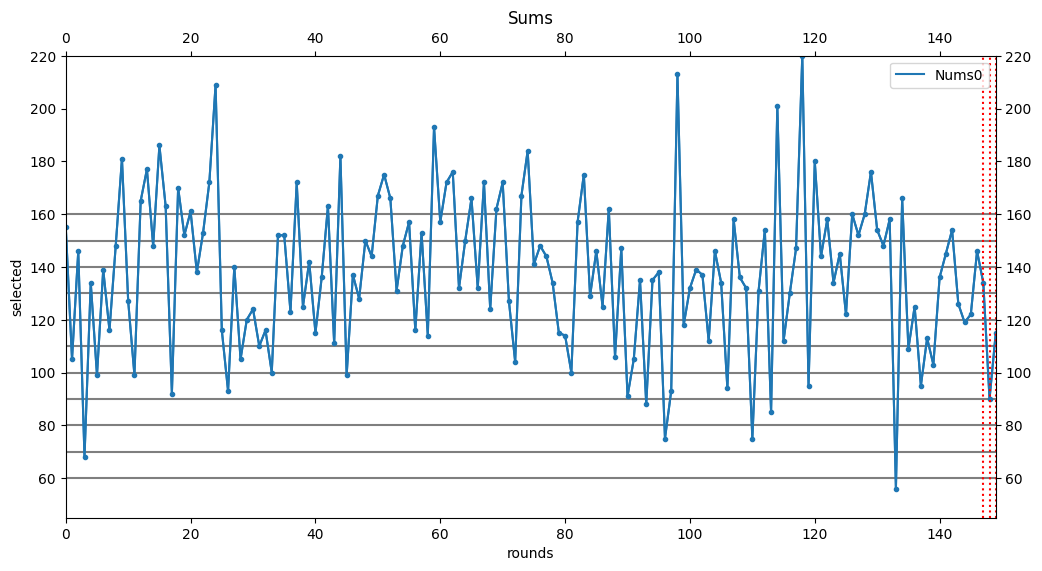

candidate =  115
candidate =  dict_values([3, 11, 12, 19, 32, 38])
last      =  [116, 91, 128, 130, 118, 162, 118, 124, 165, 174, 116, 173, 100, 194, 117, 127, 118, 109, 163, 128, 183, 112, 131, 140, 89, 196, 176, 152, 148, 105, 141, 197, 160, 123, 134, 159, 141, 146, 147, 134, 123, 163, 120, 118, 155, 182, 152, 143, 89, 163, 147, 67, 117, 131, 189, 179, 121, 164, 182, 154, 118, 137, 163, 155, 154, 130, 187, 146, 202, 132, 174, 183, 114, 115, 207, 182, 94, 150, 163, 136, 185, 131, 190, 110, 144, 105, 128, 188, 144, 128, 91, 79, 135, 127, 223, 173, 151, 139, 194, 147, 125, 164, 103, 161, 116, 122, 212, 191, 151, 109, 181, 140, 127, 130, 148, 104, 130, 128, 112, 199, 129, 159, 130, 109, 112, 121, 178, 91, 152, 121, 132, 144, 141, 115, 108, 138, 177, 184, 120, 163, 109, 85, 175, 155, 133, 191, 142, 148, 95, 116, 105, 169, 125, 157, 160, 147, 115, 134, 150, 110, 171, 190, 112, 157, 136, 144, 135, 124, 128, 154, 109, 135, 151, 166, 155, 136, 183, 133, 147, 135, 96, 136, 121, 90, 125, 199, 1

In [97]:
start_pos = 250
s1 = sums[start_pos:-1] + [sum(candidate.values())]
draw_scatter([s1], f'Sums', helper_line_nums=[60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160], show_vline=True)
print('candidate = ', sum(candidate.values()))
print('candidate = ', candidate.values())
print('last      = ', sums[:-1])
print(f'execute this code. [{datetime.now()}]')

In [98]:
def get_candidated_by_version(version, req_cols: []):
    cols = []
    for col in req_cols:
        if col >= 1 and col <= 6:
            cols.append(f'n{col-1}')
    sel_query = f'select version, {", ".join(cols)} from candidated version=\\"{version}\\";'
    print('sel_query = ', sel_query)

print(get_candidated_by_version(version, [1]))

sel_query =  select version, n0 from candidated version=\"memo_0825_3\";
None


before   = 0
ext_data = 3
after    = 11


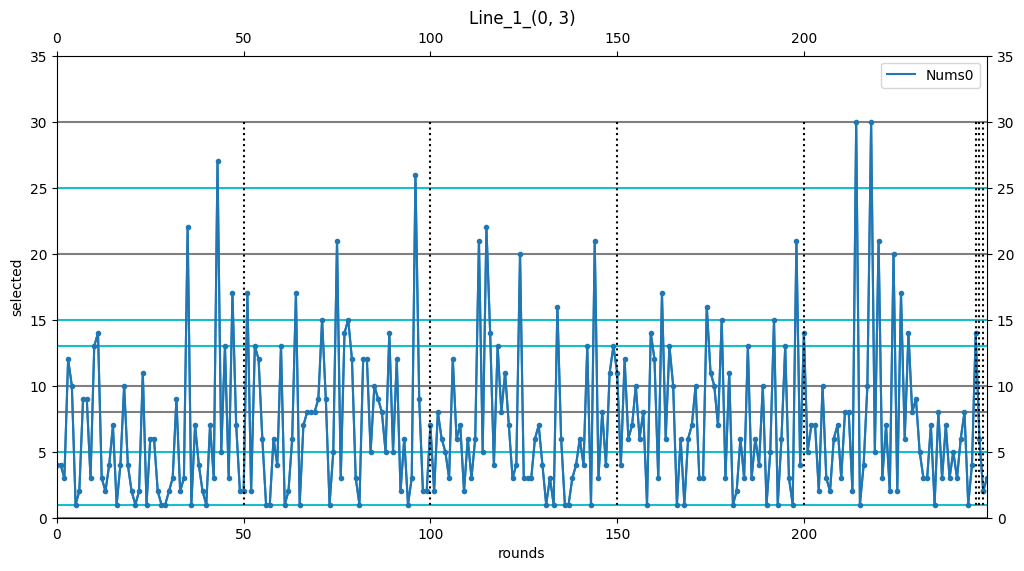

최소 값         = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 30]
최대 값         = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 30]
사용자 선택       = 3
마지막 값        = 2
마지막 값들       = [5, 21, 3, 7, 2, 20, 2, 17, 6, 14, 8, 9, 5, 3, 3, 7, 1, 8, 3, 7, 3, 5, 3, 6, 8, 1, 4, 14, 6, 2]
자주 나오는 값(부분) = [(23, 1), (27, 1), (26, 1), (18, 2), (22, 2), (30, 2), (20, 3), (19, 4), (15, 5), (17, 7), (16, 7), (21, 7), (11, 9), (13, 13), (14, 14), (12, 15), (10, 16), (9, 16), (8, 20), (5, 26), (7, 27), (4, 27), (6, 33), (2, 44), (1, 47), (3, 50)]
자주 나오는 값(전체) = [(23, 1), (27, 1), (26, 1), (18, 2), (22, 2), (30, 2), (20, 3), (19, 4), (15, 5), (17, 7), (16, 7), (21, 7), (11, 9), (13, 13), (14, 14), (12, 15), (10, 16), (9, 16), (8, 20), (5, 26), (7, 27), (4, 27), (6, 33), (2, 44), (1, 47), (3, 50)]
마지막 수의 앞과 뒤 #1 = [[-1, 2, 2], [2, 2, 3], [3, 2, 2], [2, 2, 10], [5, 2, 12], [11, 2, 17], [1, 2, 9], [3, 2, 5], [11, 2, 20], [12, 2, 21], [21, 2, 2], [2, 2, 3], [5, 2

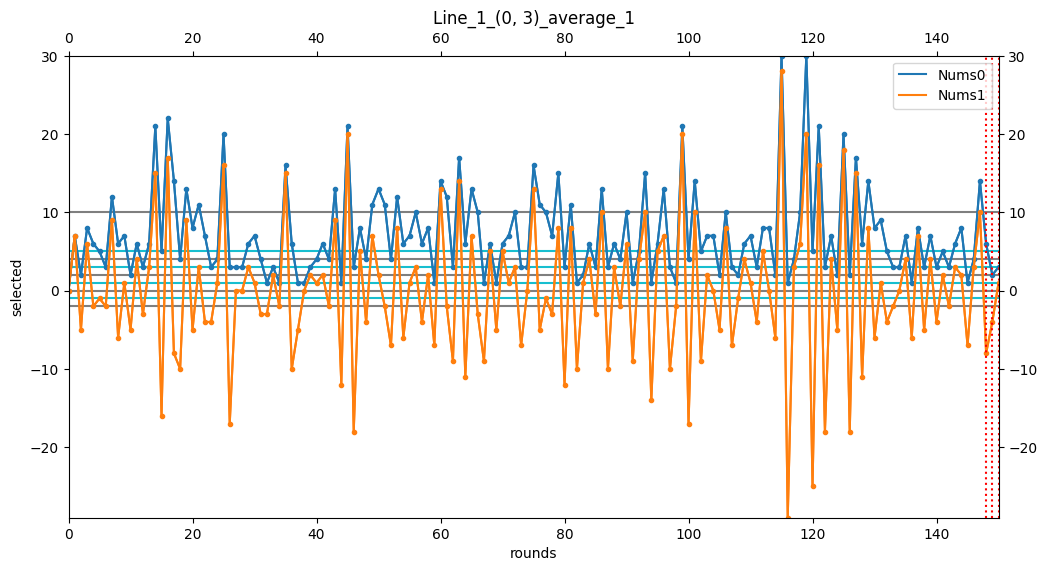

________________________________________
최소값          = [4.0, 4.2, 4.3, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1]
최대값          = [8.9, 9.0, 9.1, 9.2, 9.3, 9.6, 9.7, 10.0, 10.1, 10.2, 10.3, 10.4, 10.6, 10.7, 10.8, 11.1, 11.3, 11.4, 11.7, 11.9]
마지막          = [8.8, 9.0, 8.6, 8.7, 7.4, 7.3, 6.4, 6.1, 5.4, 4.9, 4.5, 4.3, 4.6, 5.1, 4.5, 4.8, 5.4, 5.7, 5.2, 5.2]


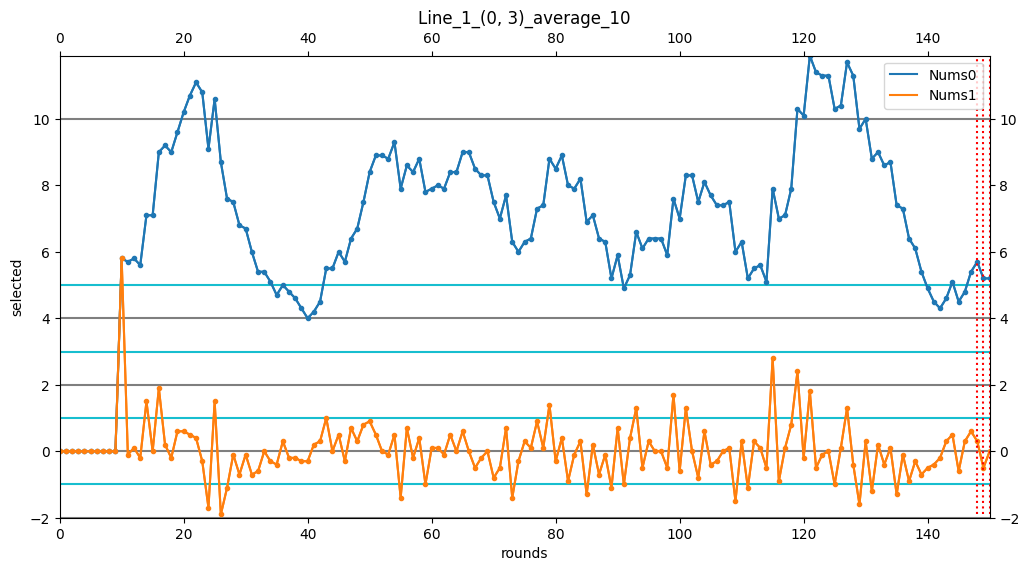

________________________________________
최소값          = [4.95, 5.05, 5.1, 5.3, 5.35, 5.45, 5.55, 5.6, 5.65, 5.9, 5.95, 6.05, 6.1, 6.2, 6.4, 6.45, 6.55, 6.6, 6.65, 6.7]
최대값          = [8.15, 8.2, 8.25, 8.35, 8.4, 8.45, 8.55, 8.6, 8.7, 8.8, 8.85, 9.05, 9.1, 9.4, 9.6, 9.95, 10.0, 10.05, 10.2, 10.35]
마지막          = [10.35, 10.2, 9.95, 10.0, 8.85, 8.85, 9.05, 8.7, 7.55, 7.45, 6.65, 6.65, 6.6, 6.9, 5.95, 6.05, 5.9, 5.9, 5.3, 5.05]


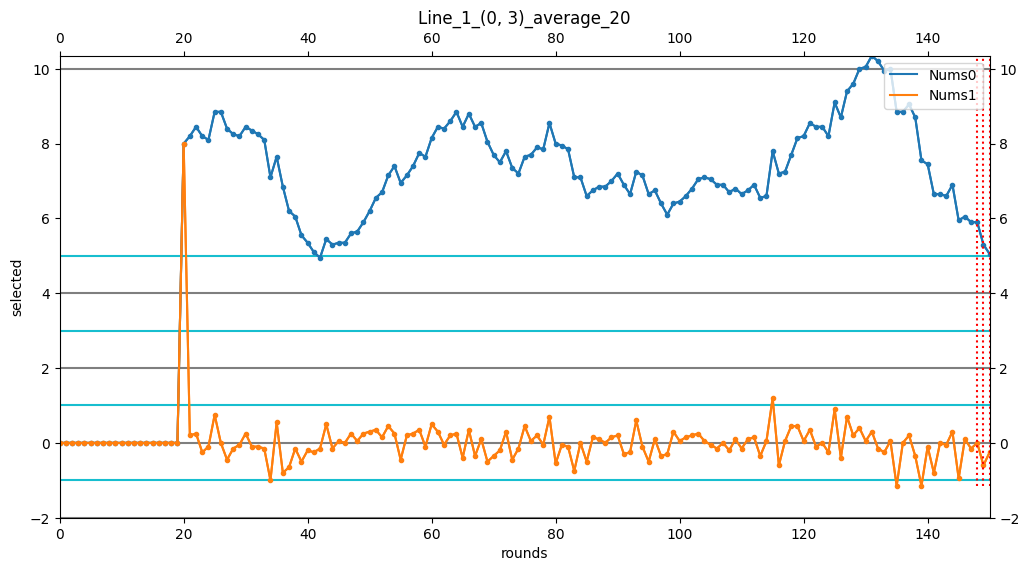

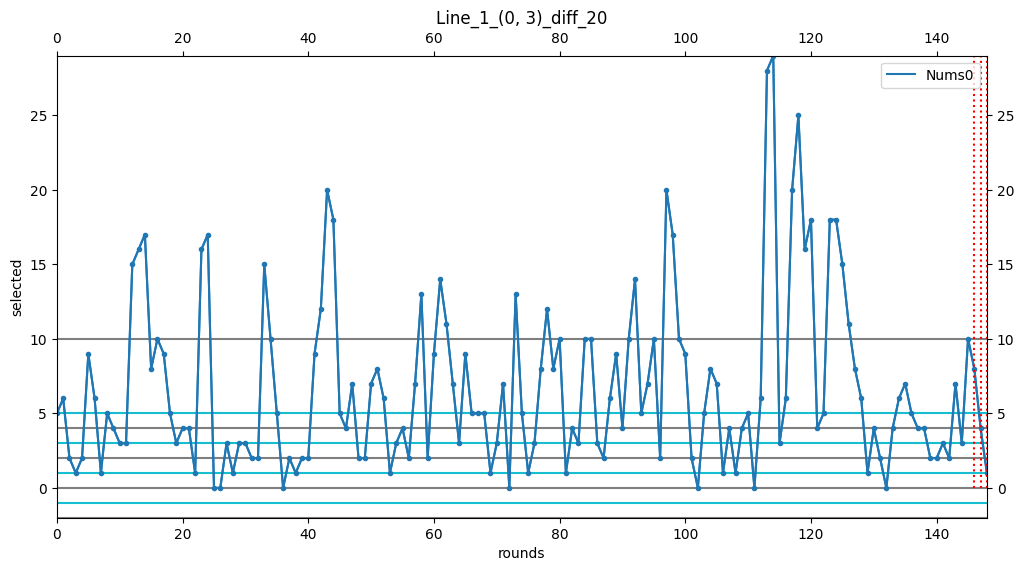

execute this code. [2025-08-27 13:46:30.729350]
10 단위 수 {0: 290, 10: 92, 20: 15, 30: 2}


In [99]:
Round = 1
############################
selected = Round - 1

if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 3

before = 0
after = candidate[selected+1]

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 30
helper_line_nums_1 = [0, 1, 5, 8, 10, 13, 15, 20, 25, 30, 35]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-2, -1, 0, 1, 2, 3, 4, 5, 10]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [1, 10, 20]
start_pos_0 = 150
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = True

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')
print('10 단위 수', get_level_count(num_data, level=10))

before   = 3
ext_data = 11
after    = 12
10 단위 분포 {0: 132, 10: 194, 20: 61, 30: 12}
5 단위 분포 {0: 30, 5: 102, 10: 109, 15: 85, 20: 43, 25: 18, 30: 11, 35: 1}


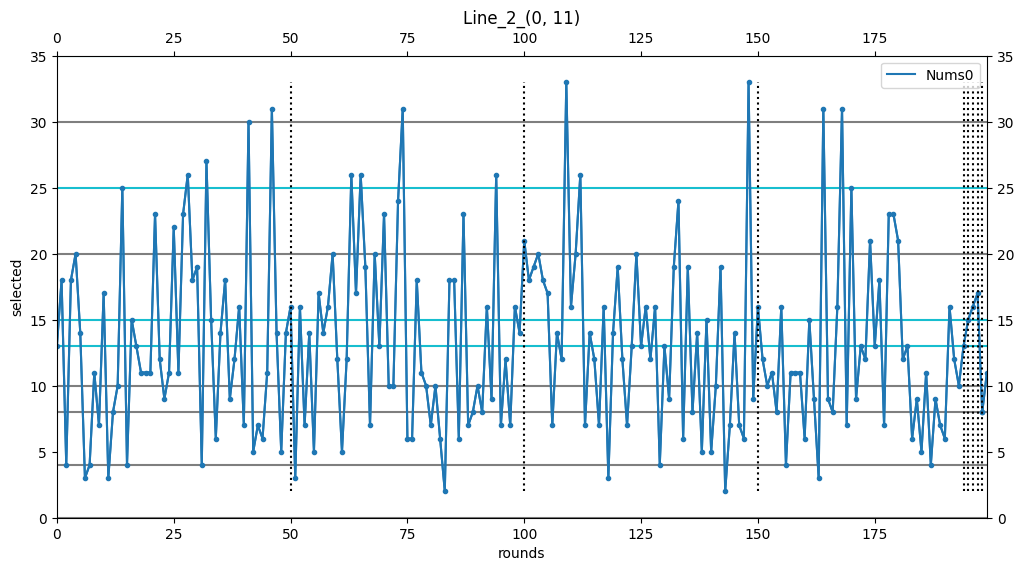

최소 값         = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 31, 33]
최대 값         = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 31, 33]
사용자 선택       = 11
마지막 값        = 8
마지막 값들       = [7, 25, 9, 13, 12, 21, 13, 18, 7, 23, 23, 21, 12, 13, 6, 9, 5, 11, 4, 9, 7, 6, 16, 12, 10, 13, 15, 16, 17, 8]
자주 나오는 값(부분) = [(30, 2), (34, 2), (33, 2), (27, 3), (22, 4), (2, 4), (31, 4), (24, 5), (25, 7), (26, 8), (23, 8), (20, 9), (3, 10), (19, 10), (5, 12), (17, 13), (4, 16), (8, 17), (21, 17), (15, 18), (13, 18), (14, 20), (12, 21), (16, 21), (6, 23), (9, 23), (18, 23), (10, 24), (11, 26), (7, 27)]
자주 나오는 값(전체) = [(30, 2), (34, 2), (33, 2), (27, 3), (22, 4), (2, 4), (31, 4), (24, 5), (25, 7), (26, 8), (23, 8), (20, 9), (3, 10), (19, 10), (5, 12), (17, 13), (4, 16), (8, 17), (21, 17), (15, 18), (13, 18), (14, 20), (12, 21), (16, 21), (6, 23), (9, 23), (18, 23), (10, 24), (11, 26), (7, 27)]
마지막 수의 앞과 뒤 #1 = [[6, 8,

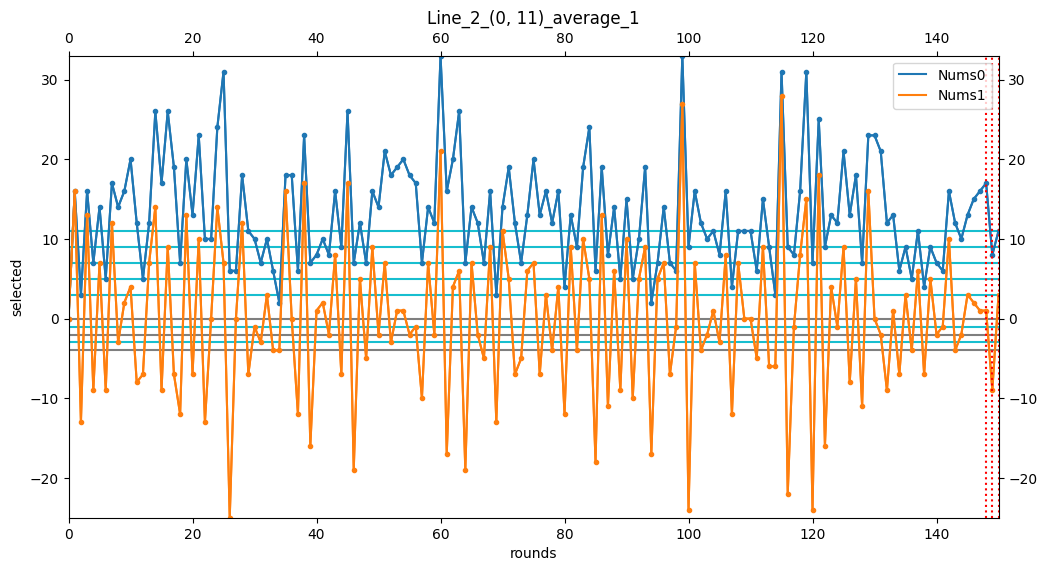

________________________________________
최소값          = [8.2, 8.5, 8.6, 8.9, 9.0, 9.3, 9.4, 9.7, 9.8, 9.9, 10.0, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 11.0, 11.1]
최대값          = [15.5, 15.6, 15.7, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.3, 17.4, 17.6, 17.9, 18.3]
마지막          = [16.0, 16.3, 16.3, 15.7, 14.5, 13.7, 13.0, 12.7, 11.3, 9.7, 8.2, 8.6, 8.5, 8.9, 9.3, 10.3, 10.8, 12.1, 12.0, 12.4]


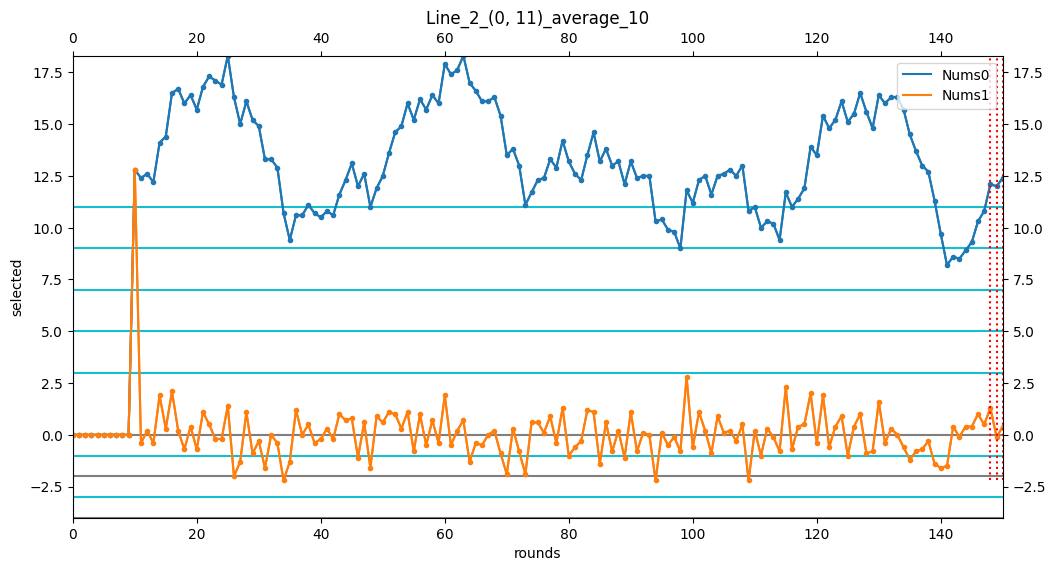

________________________________________
최소값          = [10.9, 10.95, 11.0, 11.05, 11.1, 11.15, 11.25, 11.3, 11.35, 11.4, 11.5, 11.6, 11.65, 11.8, 11.85, 11.9, 11.95, 12.0, 12.05, 12.1]
최대값          = [14.95, 15.0, 15.05, 15.2, 15.3, 15.5, 15.55, 15.6, 15.7, 15.75, 15.8, 15.85, 15.9, 16.05, 16.1, 16.15, 16.35, 16.4, 16.5, 16.6]
마지막          = [15.7, 15.55, 15.75, 15.9, 14.8, 14.6, 14.75, 14.15, 13.05, 13.05, 12.1, 12.45, 12.4, 12.3, 11.9, 12.0, 11.9, 12.4, 11.65, 11.05]


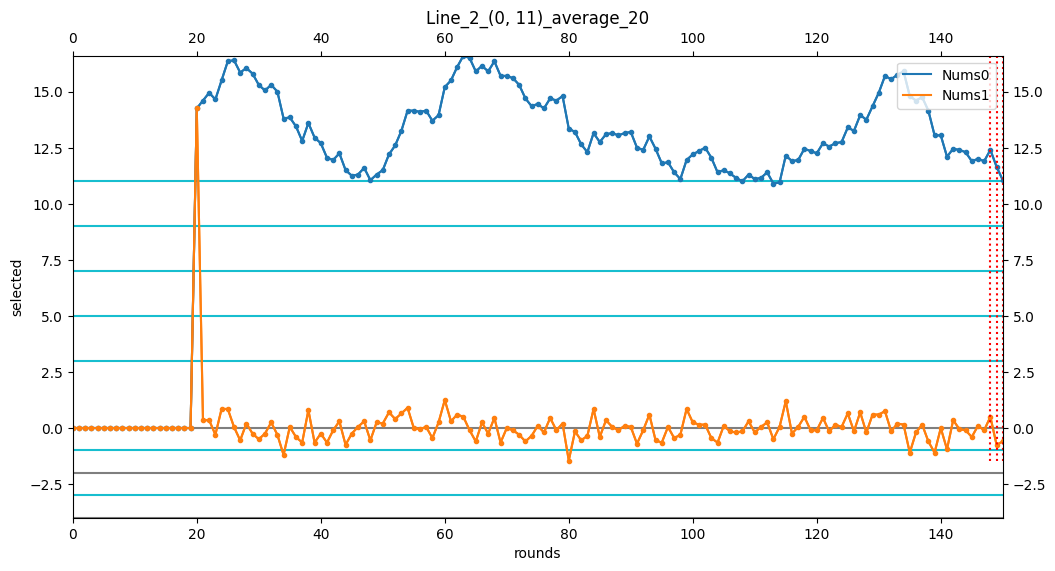

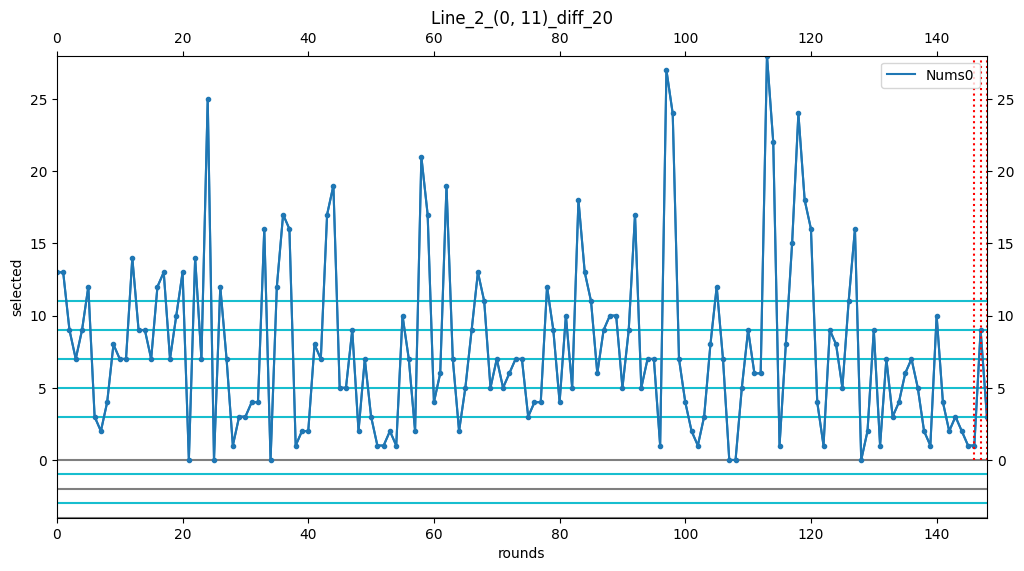

execute this code. [2025-08-27 13:46:32.026772]


In [100]:
Round = 2
############################
selected = Round - 1
if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 11

before = candidate[selected-1]
after = candidate[selected+1]

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 30
helper_line_nums_1 = [0, 4, 8, 10, 13, 15, 20, 25, 30, 35]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-4, -3, -2, -1, 0, 3, 5, 7, 9, 11]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [1, 10, 20]
start_pos_0 = 200
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = True

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))
vline_poses.append((len(row_list_none_last[selected])-start_pos_0-4, 0, 45))
vline_poses.append((len(row_list_none_last[selected])-start_pos_0-5, 0, 45))


print('10 단위 분포', get_level_count(num_data, level=10))
print('5 단위 분포', get_level_count(num_data, level=5))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')

before   = 11
ext_data = 12
after    = 19
10 단위 분포 {0: 18, 10: 185, 20: 144, 30: 51, 40: 1}
5 단위 분포 {0: 1, 5: 17, 10: 86, 15: 99, 20: 81, 25: 63, 30: 43, 35: 8, 40: 1}


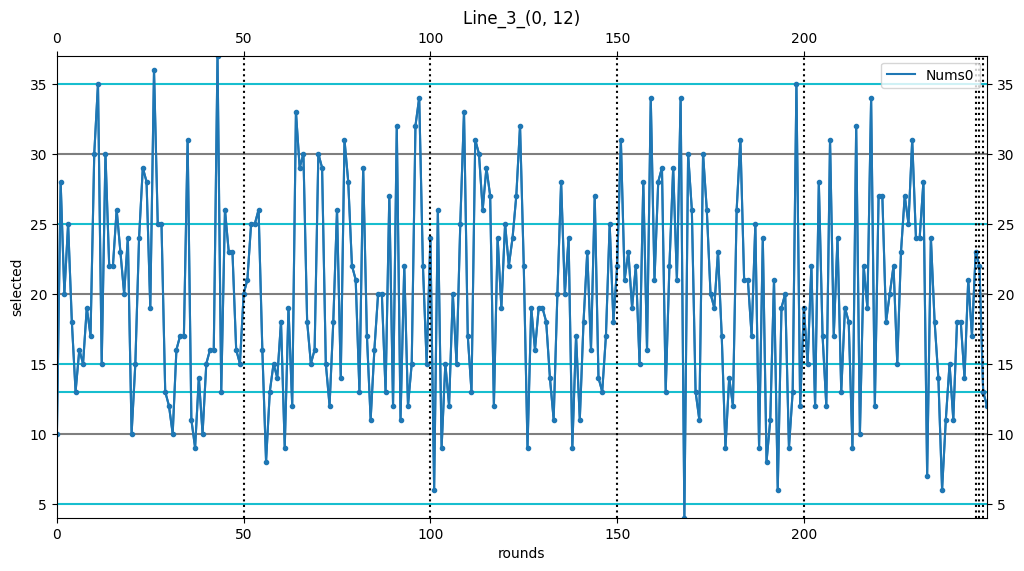

최소 값         = [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
최대 값         = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
사용자 선택       = 12
마지막 값        = 13
마지막 값들       = [12, 27, 27, 18, 20, 22, 15, 23, 27, 25, 31, 24, 24, 28, 7, 24, 18, 14, 6, 11, 15, 11, 18, 18, 14, 21, 17, 23, 22, 13]
자주 나오는 값(부분) = [(37, 2), (33, 3), (35, 3), (8, 3), (6, 3), (34, 6), (27, 7), (32, 8), (10, 9), (9, 9), (26, 12), (31, 12), (21, 13), (14, 13), (29, 13), (25, 14), (30, 14), (11, 15), (23, 15), (28, 17), (20, 17), (24, 17), (15, 18), (22, 19), (16, 19), (18, 20), (17, 20), (19, 22), (13, 24), (12, 25)]
자주 나오는 값(전체) = [(37, 2), (33, 3), (35, 3), (8, 3), (6, 3), (34, 6), (27, 7), (32, 8), (10, 9), (9, 9), (26, 12), (31, 12), (21, 13), (14, 13), (29, 13), (25, 14), (30, 14), (11, 15), (23, 15), (28, 17), (20, 17), (24, 17), (15, 18), (22, 19), (16, 19), (18, 20), (

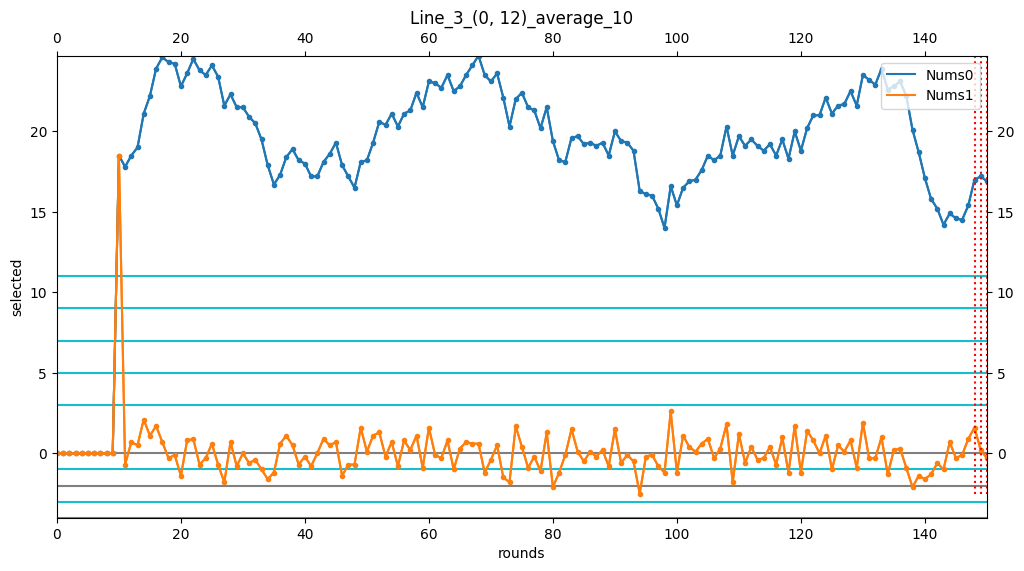

execute this code. [2025-08-27 13:46:32.670929]


In [101]:
Round = 3
############################
selected = Round - 1
if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 12

before = candidate[selected-1]
after = candidate[selected+1]

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 30
helper_line_nums_1 = [5, 10, 13, 15, 20, 25, 30, 35]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-4, -3, -2, -1, 0, 3, 5, 7, 9, 11]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [10]
start_pos_0 = 150
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = False

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))

print('10 단위 분포', get_level_count(num_data, level=10))
print('5 단위 분포', get_level_count(num_data, level=5))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')

before   = 12
ext_data = 19
after    = 32
10 단위 분포 {0: 1, 10: 78, 20: 171, 30: 138, 40: 11}
5 단위 분포 {5: 1, 10: 25, 15: 53, 20: 80, 25: 91, 30: 85, 35: 53, 40: 11}


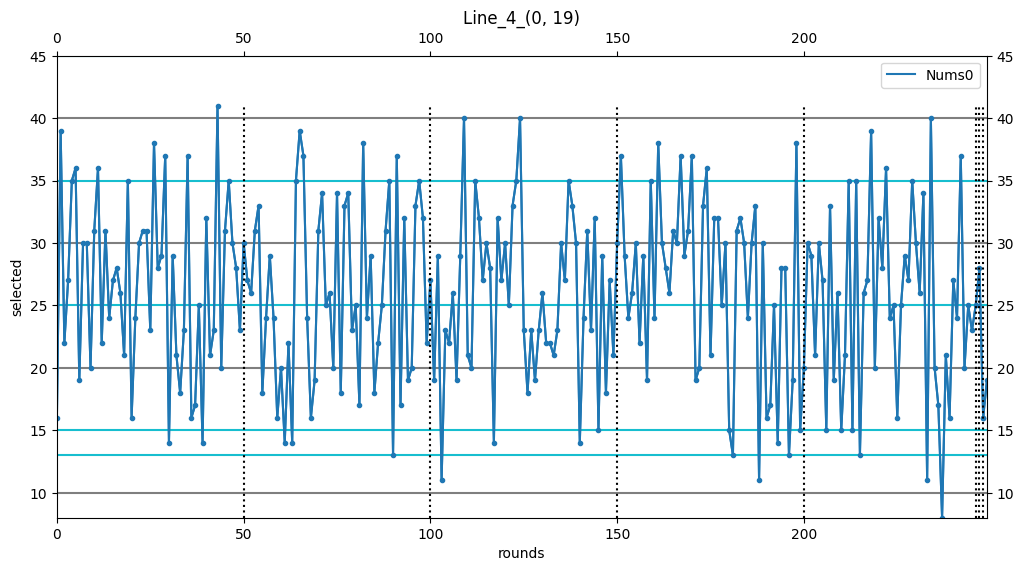

최소 값         = [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
최대 값         = [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
사용자 선택       = 19
마지막 값        = 16
마지막 값들       = [20, 32, 28, 36, 24, 25, 16, 25, 29, 27, 35, 30, 26, 34, 11, 40, 20, 17, 8, 21, 16, 27, 24, 37, 20, 25, 23, 25, 28, 16]
자주 나오는 값(부분) = [(11, 3), (39, 4), (41, 4), (40, 5), (36, 7), (34, 8), (17, 8), (13, 8), (15, 8), (37, 10), (16, 10), (14, 11), (18, 13), (38, 13), (20, 13), (19, 14), (33, 15), (25, 16), (24, 16), (22, 17), (21, 17), (29, 17), (28, 17), (23, 17), (27, 18), (32, 18), (31, 19), (35, 19), (26, 23), (30, 25)]
자주 나오는 값(전체) = [(11, 3), (39, 4), (41, 4), (40, 5), (36, 7), (34, 8), (17, 8), (13, 8), (15, 8), (37, 10), (16, 10), (14, 11), (18, 13), (38, 13), (20, 13), (19, 14), (33, 15), (25, 16), (24, 16), (22, 17), (21, 17), (29, 17), (28, 17), (23, 17), (27, 

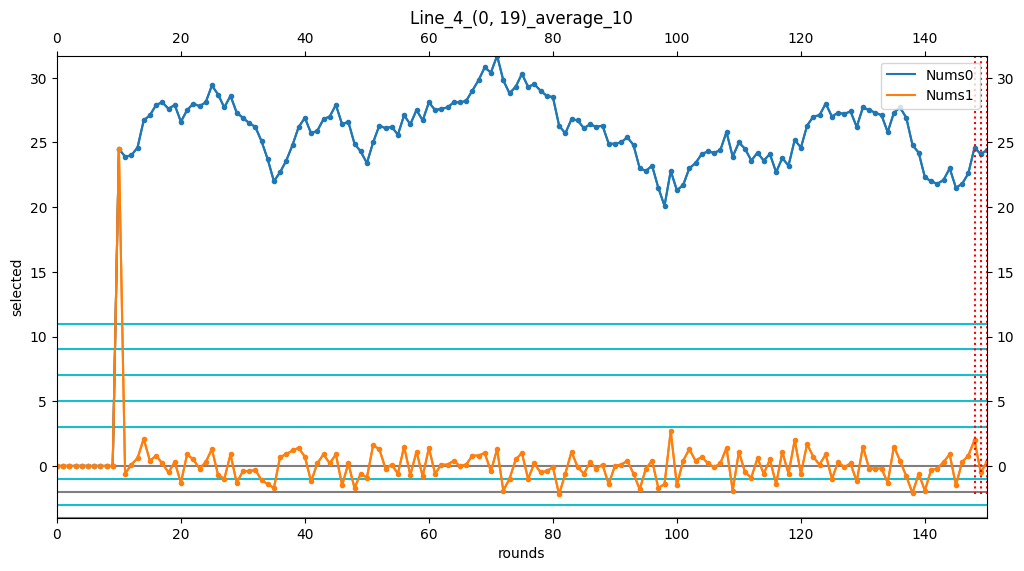

execute this code. [2025-08-27 13:46:33.289566]


In [102]:
Round = 4
############################
selected = Round - 1
if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 19

before = candidate[selected-1]
after = candidate[selected+1]

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 30
helper_line_nums_1 = [10, 13, 15, 20, 25, 30, 35, 40, 45]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-4, -3, -2, -1, 0, 3, 5, 7, 9, 11]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [10]
start_pos_0 = 150
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = False

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))

print('10 단위 분포', get_level_count(num_data, level=10))
print('5 단위 분포', get_level_count(num_data, level=5))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')

before   = 19
ext_data = 32
after    = 38
10 단위 분포 {10: 15, 20: 101, 30: 216, 40: 67}


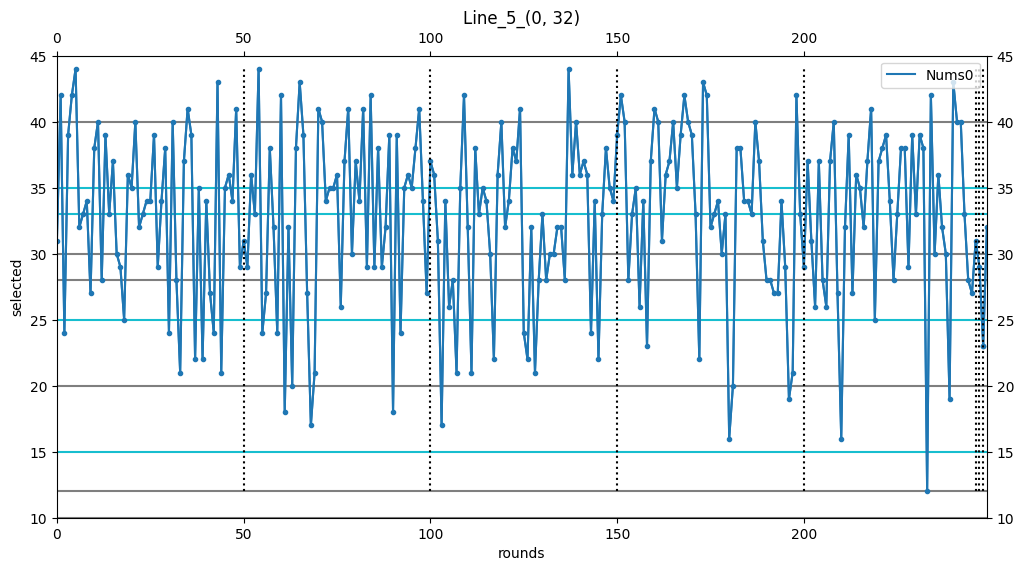

최소 값         = [12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
최대 값         = [12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
사용자 선택       = 32
마지막 값        = 23
마지막 값들       = [33, 29, 37, 31, 26, 37, 28, 26, 37, 40, 27, 16, 32, 39, 27, 36, 35, 32, 37, 41, 25, 37, 38, 39, 34, 28, 33, 38, 38, 29, 39, 33, 39, 38, 12, 42, 30, 36, 32, 30, 19, 43, 40, 40, 33, 28, 27, 31, 29, 23]
자주 나오는 값(부분) = [(13, 1), (15, 1), (12, 1), (20, 2), (17, 2), (16, 3), (18, 3), (19, 4), (44, 4), (23, 5), (25, 7), (21, 7), (26, 8), (22, 10), (24, 11), (43, 12), (31, 13), (41, 13), (30, 14), (28, 16), (29, 17), (32, 17), (42, 18), (27, 18), (35, 19), (40, 20), (38, 21), (36, 22), (37, 23), (39, 28), (33, 29), (34, 30)]
자주 나오는 값(전체) = [(13, 1), (15, 1), (12, 1), (20, 2), (17, 2), (16, 3), (18, 3), (19, 4), (44, 4), (23, 5), (25, 7), (21, 7), (26, 8), (22, 10), (24, 11), (43, 12)

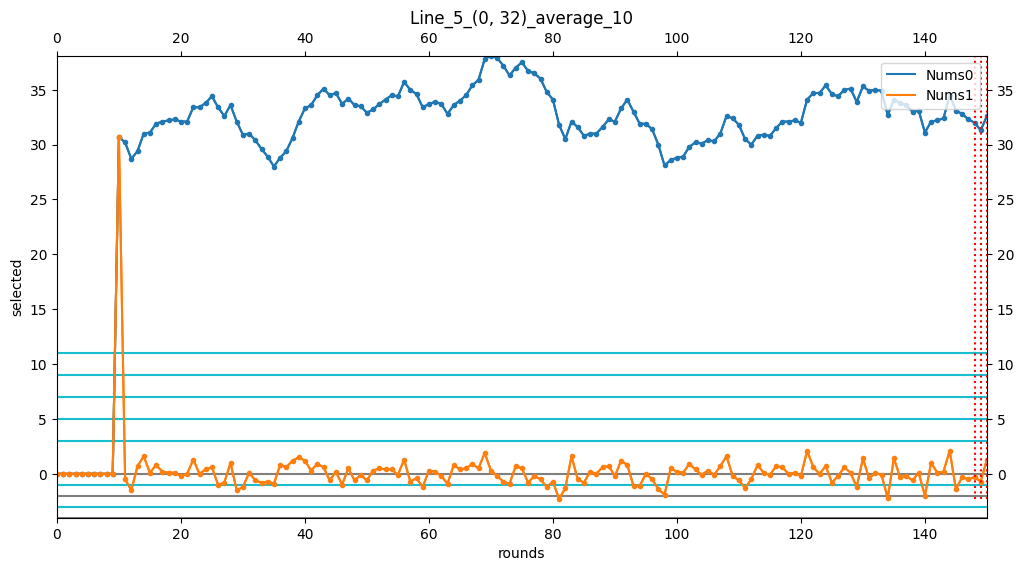

execute this code. [2025-08-27 13:46:33.926723]


In [103]:
Round = 5
############################
selected = Round - 1

if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 32

before = candidate[selected-1]
after = candidate[selected+1]

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 50
helper_line_nums_1 = [10, 12, 15, 20, 25, 28, 30, 33, 35, 40, 45]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-4, -3, -2, -1, 0, 3, 5, 7, 9, 11]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [10]
start_pos_0 = 150
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = False

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))

print('10 단위 분포', get_level_count(num_data, level=10))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')

before   = 32
ext_data = 38
after    = 46
10 단위 수 {10: 3, 20: 19, 30: 144, 40: 233}


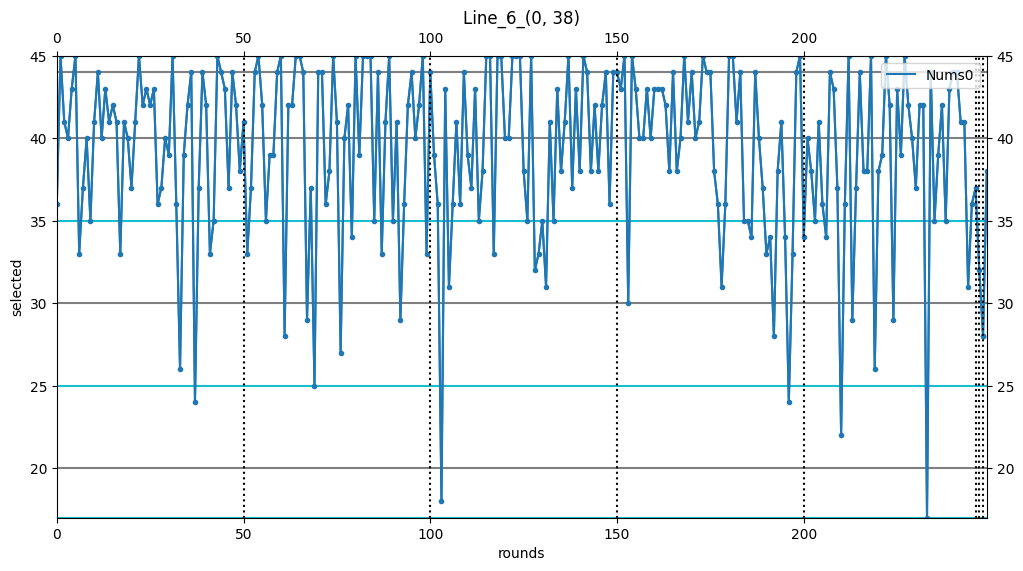

최소 값         = [17, 18, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
최대 값         = [17, 18, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
사용자 선택       = 38
마지막 값        = 28
마지막 값들       = [26, 38, 39, 45, 42, 29, 43, 39, 45, 42, 40, 37, 42, 42, 17, 44, 35, 39, 42, 35, 43, 44, 44, 41, 41, 31, 36, 37, 32, 28]
자주 나오는 값(부분) = [(19, 1), (23, 1), (27, 1), (18, 1), (22, 1), (17, 1), (30, 2), (25, 2), (26, 2), (24, 2), (28, 5), (29, 5), (32, 6), (31, 6), (34, 8), (33, 10), (37, 17), (35, 18), (40, 22), (36, 23), (39, 24), (41, 28), (38, 30), (42, 35), (43, 39), (44, 49), (45, 60)]
자주 나오는 값(전체) = [(19, 1), (23, 1), (27, 1), (18, 1), (22, 1), (17, 1), (30, 2), (25, 2), (26, 2), (24, 2), (28, 5), (29, 5), (32, 6), (31, 6), (34, 8), (33, 10), (37, 17), (35, 18), (40, 22), (36, 23), (39, 24), (41, 28), (38, 30), (42, 35), (43, 39), (44, 49), (45, 60)]
마지막 수의 앞과 뒤 #1 = [[45, 28, 45], [39, 28, 45], [45, 28, 42], [34, 28, 3

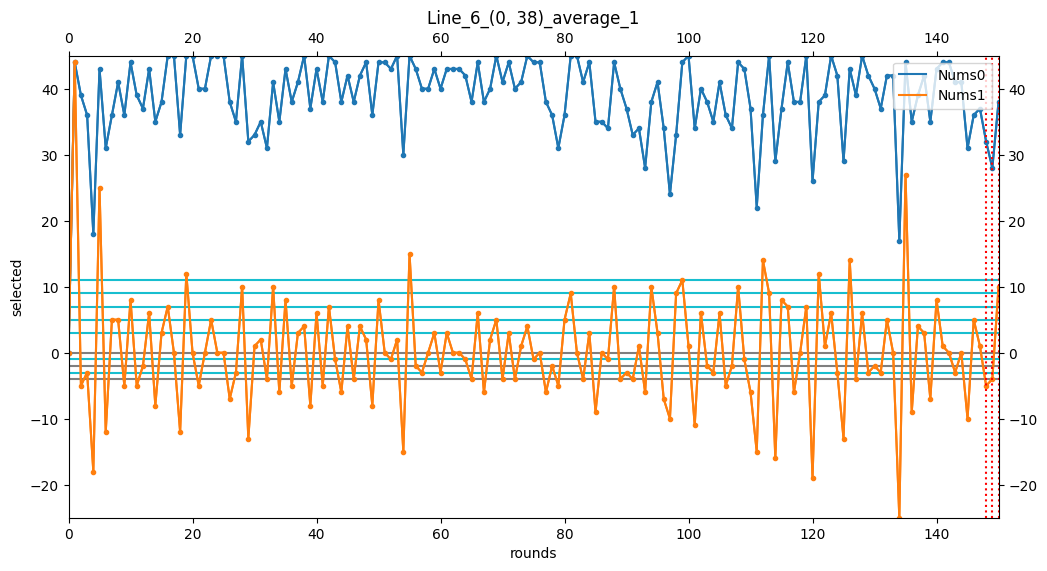

________________________________________
최소값          = [34.2, 34.6, 35.3, 35.4, 35.5, 35.8, 36.0, 36.1, 36.3, 36.4, 36.6, 36.7, 36.8, 36.9, 37.0, 37.1, 37.2, 37.3, 37.4, 37.5]
최대값          = [40.2, 40.3, 40.4, 40.5, 40.6, 40.8, 40.9, 41.0, 41.1, 41.2, 41.3, 41.4, 41.5, 41.6, 41.7, 41.8, 42.1, 42.2, 42.3, 42.8]
마지막          = [40.1, 40.4, 40.1, 37.6, 39.1, 38.3, 38.3, 38.0, 37.3, 37.6, 38.3, 38.5, 38.4, 40.8, 39.5, 39.6, 39.4, 38.4, 37.7, 37.2]


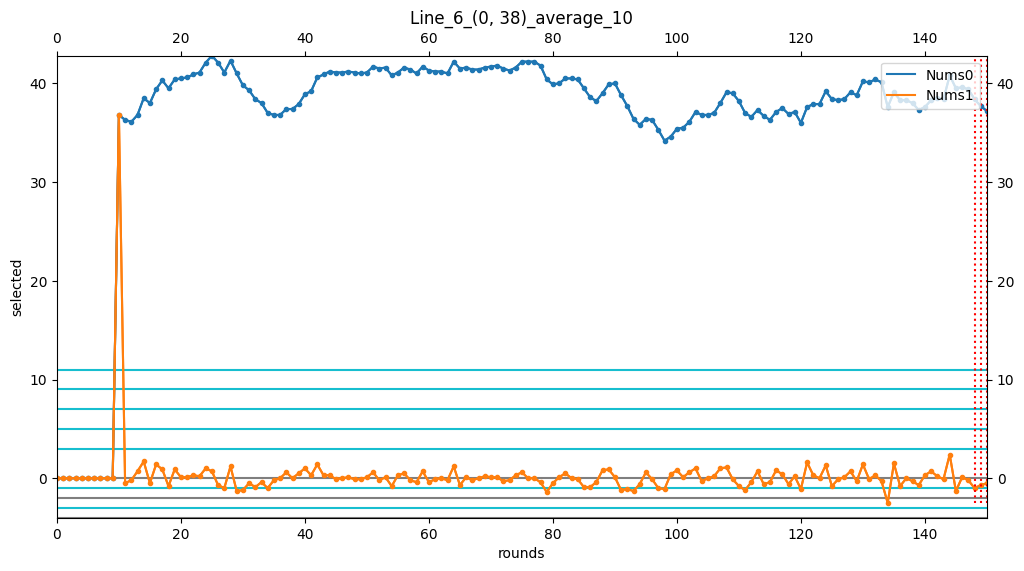

________________________________________
최소값          = [36.25, 36.3, 36.35, 36.55, 36.6, 36.65, 36.75, 36.8, 36.9, 37.05, 37.1, 37.15, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.5, 37.6]
최대값          = [40.75, 40.8, 40.85, 40.9, 41.0, 41.05, 41.1, 41.15, 41.2, 41.25, 41.3, 41.35, 41.4, 41.45, 41.5, 41.6, 41.65, 41.8, 41.85, 41.9]
마지막          = [38.85, 39.15, 39.0, 38.4, 38.75, 38.3, 38.35, 38.55, 38.05, 38.9, 39.2, 39.45, 39.25, 39.2, 39.3, 38.95, 38.85, 38.2, 37.5, 37.4]


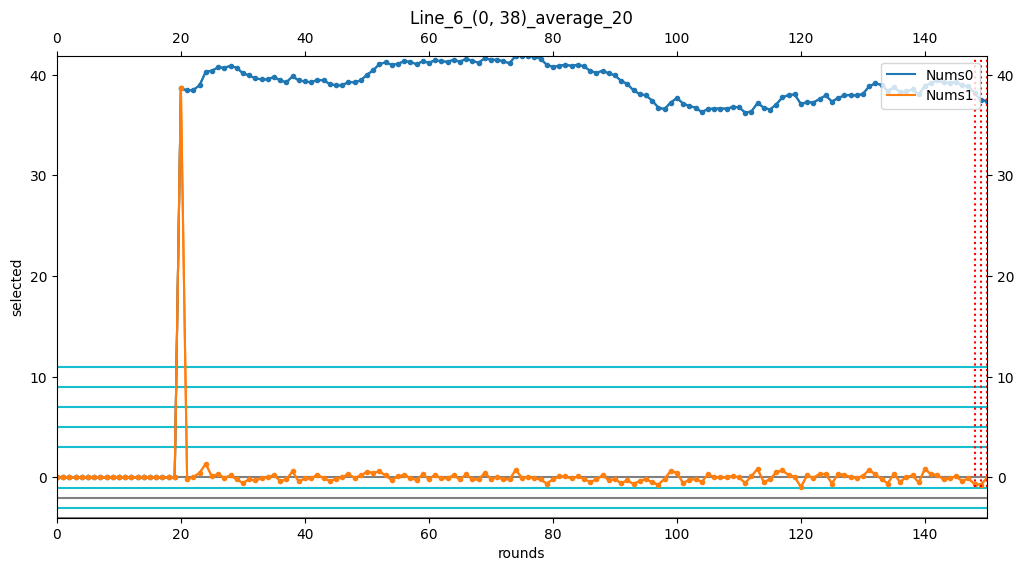

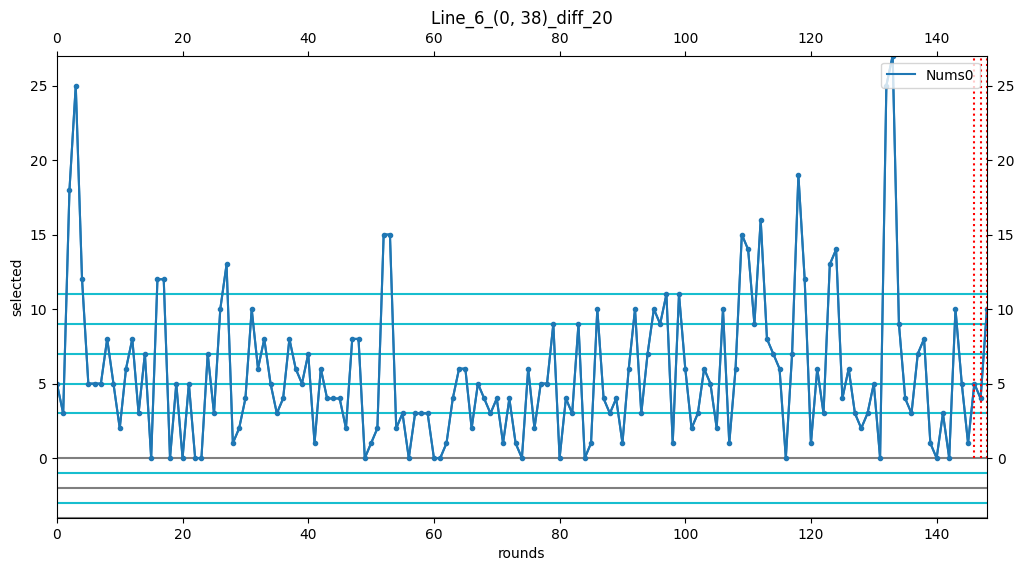

execute this code. [2025-08-27 13:46:34.827767]


In [104]:
Round = 6
############################
selected = Round - 1
if op_with_re:
    ext_data = candidate[selected]
else:
    ext_data = 38

before = candidate[selected-1]
after = 46

print(f"before   = {before}")
print(f"ext_data = {ext_data}")
print(f"after    = {after}")

wanted_data_length = 30
helper_line_nums_1 = [17, 20, 25, 30, 35, 40, 44, 45]
# helper_line_nums_2 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 7, 9, 11]
helper_line_nums_2 = [-4, -3, -2, -1, 0, 3, 5, 7, 9, 11]
# lengths = [2, 5, 8, 10, 13, 15, 20, 25, 30]
lengths = [1, 10, 20]
start_pos_0 = 150
start_pos_1 = 250
num_data=row_list_none_last[selected]
show_after = False
show_before = False
show_average = True
min_max_last_num_length = 20
show_diff_nums = True

ext_datas = get_extdatas(show_before, show_after, before, ext_data, after)

show_data = []
for i in range(6):
    show_data.append(row_list[i][start_pos:])

vline_poses = []
for i in range(1, (len(row_list_none_last[selected]) - start_pos_0) // 50 +1):
    vline_poses.append((50*i, 0, 45))

print('10 단위 수', get_level_count(num_data, level=10))

get_information_v2(selected=selected,
                   last_results=row_list_none_last,
                   ext_datas=ext_datas,
                   wanted_data_length=wanted_data_length,
                   helper_line_nums_1=helper_line_nums_1,
                   helper_line_nums_2=helper_line_nums_2,
                   show_diff=True,
                   lengths=lengths,
                   start_pos_0=start_pos_0,
                   start_pos_1=start_pos_1,
                   show_after=show_after,
                   show_before=show_before,
                   show_average=show_average,
                   min_max_last_num_length=min_max_last_num_length,
                   show_diff_nums=show_diff_nums,
                   vline_poses=vline_poses
                   )
candidate[selected] = ext_data
update_candidated(candidated={selected: ext_data}, version=version)
print(f'execute this code. [{datetime.now()}]')

In [105]:
print(candidate)

{0: 3, 1: 11, 2: 12, 3: 19, 4: 32, 5: 38}


In [106]:
print('now = ', datetime.now())

now =  2025-08-27 13:46:35.081338
